In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ]
)

# Load Training Dataset (Train 2012)
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=transform)

# Load Test Dataset (Val 2012, since VOC does not have a separate test set)
test_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

100%|██████████| 2.00G/2.00G [01:56<00:00, 17.2MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [24]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=21):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64,128)
        self.enc4 = self.conv_block(128,256)

        # Bottleneck
        self.bottleneck = self.conv_block(256,512)

        # Decoder (Upsampling)
        self.dec4 = self.upconv(512,256)
        self.dec3 = self.upconv(256, 128)
        self.dec2 = self.upconv(128, 64)
        self.dec1 = self.upconv(64,32)

        # Final Output Layer
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block: 2 conv layers + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def upconv(self, in_channels, out_channels):
        """Upsampling + Convolution"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, kernel_size=2, stride=2))
        e3 = self.enc3(F.max_pool2d(e2, kernel_size=2, stride=2))
        e4 = self.enc4(F.max_pool2d(e3, kernel_size=2, stride=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2, stride=2))

        # Decoder with Skip Connections
        d4 = self.dec4(b) + e4  # Skip connection
        d3 = self.dec3(d4) + e3
        d2 = self.dec2(d3) + e2
        d1 = self.dec1(d2) + e1

        # Final output layer
        return self.final_conv(d1)



In [30]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.shape
        y = self.global_avg_pool(x).view(batch_size, channels)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch_size, channels, 1, 1)
        return x * y  # 🔥 Scale input feature maps

# 🔥 U-Net with SE Blocks
class UNetSE(nn.Module):
    def __init__(self, in_channels=3, out_channels=21):
        super(UNetSE, self).__init__()

        # 🔥 Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(512, 1024)

        # 🔥 Decoder (Upsampling)
        self.up4 = self.upconv_block(1024, 512)
        self.up3 = self.upconv_block(512, 256)
        self.up2 = self.upconv_block(256, 128)
        self.up1 = self.upconv_block(128, 64)

        # 🔥 Final Segmentation Layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Two 3x3 convolutions + SE Block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)  # 🔥 SE Block added here
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling + Convolution Block with SE"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)  # 🔥 SE inside decoder too
        )

    def forward(self, x):
        # 🔥 Encoder Path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        # 🔥 Decoder Path with Skip Connections
        dec4 = self.up4(bottleneck) + enc4
        dec3 = self.up3(dec4) + enc3
        dec2 = self.up2(dec3) + enc2
        dec1 = self.up1(dec2) + enc1

        return self.final_conv(dec1)  # Raw logits (NO softmax)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
model = UNetSE(in_channels=3, out_channels=21).to(device)  # 21 classes for Pascal VOC

# Loss and Optimizer
weights = torch.tensor([0.05] + [1.0] * 20).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)  # Use CrossEntropyLoss for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)  # Convert masks to long type

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))  # Squeeze to match shape
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.9119
Epoch 2/5, Loss: 0.5865


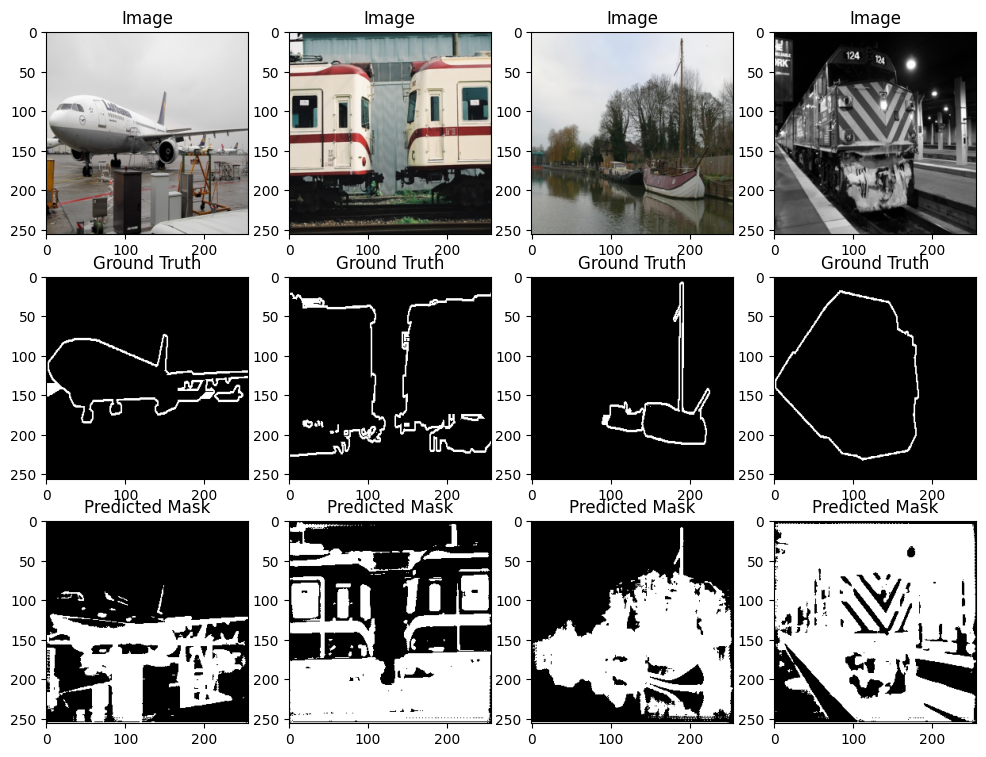

In [17]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device, dtype=torch.long)

    outputs = model(images)
    predicted_masks = torch.argmax(outputs, dim=1)

    # Convert to numpy for visualization
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    masks_np = masks.squeeze(1).cpu().numpy()
    preds_np = predicted_masks.cpu().numpy()

    # Plot sample image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):  # Show 4 samples
        axes[0, i].imshow(images_np[i])
        axes[0, i].set_title("Image")
        axes[1, i].imshow(masks_np[i], cmap="gray")
        axes[1, i].set_title("Ground Truth")
        axes[2, i].imshow(preds_np[i], cmap="gray")
        axes[2, i].set_title("Predicted Mask")
    plt.show()